In [1]:
import sys
sys.path.append('/home/lumargot/hysterectomy-coach/src/py')

In [33]:
from torchvision.ops import nms

import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import itertools
import json
from collections import defaultdict
import SimpleITK as sitk
import seaborn as sns
import glob 
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from nets.segmentation import MaskRCNN
from utils import *
from loaders.hyst_dataset import HystDataModuleSeg, TrainTransformsSeg, EvalTransformsSeg

In [ ]:
df_test = pd.read_csv('/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/csv/dataset_test.csv')

In [4]:
img_column = 'img_path'
seg_column = 'seg_path'
class_column = 'class'

mount_point = '/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/'
mask_dir = '/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/customROI/masks'
pred_file = '/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/customROI/predictions.pickle'

# mount_point = '/MEDUSA_STOR/jprieto/surgery_tracking/'
# mask_dir = '/MEDUSA_STOR/jprieto/surgery_tracking/masks'
# pred_file = '/MEDUSA_STOR/jprieto/surgery_tracking/predictions.pickle'

In [5]:
with open(pred_file, 'rb') as f:
  data = pickle.load(f)

# Evaluation of model performance's 

In [10]:
""" 2. Evaluate metrics at multiple IoU thresholds:
    precision and recall at various confidence thresholds.
"""

def compute_ap_at_iou(dic_gt, dic_pred, iou_threshold):
    """Compute AP for a single IoU threshold."""

    matched = set()
    pred_boxes = dic_pred['cls_pred_boxes']
    pred_scores = dic_pred['cls_pred_scores']

    gt_boxes = dic_gt['cls_gt_boxes']

    tp_bb = np.zeros(len(pred_boxes))
    fp_bb = np.zeros(len(pred_boxes))
    
    indices = np.arange(len(pred_boxes))
    for i, pred_box in zip(indices, pred_boxes):
        if pred_scores[i] < 0.0:  # Skip invalid detections
            fp_bb[i] = 1
            continue
        
        ## box
        best_iou_box = 0.0
        best_match_box = -1
        for j, gt_box in enumerate(gt_boxes):
            if j in matched: # avoid overlapped bounding boxes to be counted twice
                continue
            iou = compute_bbx_iou(gt_box, pred_box)
            if iou > best_iou_box:
                best_iou_box = iou
                best_match_box = j

        if best_iou_box >= iou_threshold:
            tp_bb[i] = 1
            matched.add(best_match_box)            
        else:
            fp_bb[i] = 1

    tp_cumsum_bb = np.cumsum(tp_bb)
    fp_cumsum_bb = np.cumsum(fp_bb)
    
    print(tp_cumsum_bb.shape)
    p_bb = tp_cumsum_bb / (tp_cumsum_bb + fp_cumsum_bb + 1e-6)
    r_bb = tp_cumsum_bb / len(gt_boxes)

    if len(r_bb) < 2 or len(p_bb) < 2:
        return 0.0, 0.0  # Default AP value if AUC cannot be computed

    print(auc(r_bb, p_bb))

    return auc(r_bb, p_bb)

In [11]:
""" 3. Compute Average Precision (AP):
    Integrate precision-recall curves for the desired IoU thresholds
"""

def compute_map_multiclass(data, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    """
    Compute mAP for multiclass detection.
    
    Parameters:
        data: List of dicts. Each dict contains the labels and boxes of both predictions and ground truth + confidence scores of the predictions.
        iou_thresholds: List of IoU thresholds.
    
    Returns:
        mAP: Mean Average Precision across all classes and IoU thresholds.
        class_aps: AP per class.
    """
    all_classes = set()
    for dict in data:
        for label in dict['gt_labels']:
            all_classes.add(label)

    # class_aps_mask = {}
    class_aps_box = {}

    for cls in all_classes:
        cls_pred_boxes = []
        cls_pred_scores = []
        cls_pred_masks = []

        cls_gt_boxes = []
        cls_gt_masks = []

        # Collect predictions and ground truths for the current class
        for elt_dict in data:

            # print((pred), gt) # dict, dict 
            for box, label, score, in zip(elt_dict['pred_boxes'], elt_dict['pred_labels'], elt_dict['pred_scores']):
                if label == cls:
                    cls_pred_boxes.append(box)
                    # cls_pred_masks.append(mask)
                    cls_pred_scores.append(score)

            for box, label in zip(elt_dict['gt_boxes'], elt_dict['gt_labels']):
                if label == cls:
                    cls_gt_boxes.append(box)
                    # cls_gt_masks.append(mask)

        dic_cls_gt = {'cls_gt_boxes':cls_gt_boxes}
        dic_cls_pred = {'cls_pred_boxes':cls_pred_boxes, 'cls_pred_scores':cls_pred_scores}

        if len(cls_gt_boxes) == 0:
            continue  # Skip classes without ground truths

        box_aps = []
        for iou_threshold in iou_thresholds:
            bb_ap = compute_ap_at_iou(dic_cls_gt, dic_cls_pred, iou_threshold)
            box_aps.append(bb_ap)

        class_aps_box[cls] = np.mean(box_aps)

    box_mAP = np.mean(list(class_aps_box.values()))

    return box_mAP, class_aps_box

In [32]:
num_preds, num_fps, num_fns = 0, 0, 0
l_ious, l_distances = [], []
gt, pred = [], []
l_dice = []
for out_img in data:
  pred_boxes = out_img['pred_boxes']
  pred_scores = out_img['pred_scores']
  pred_path = out_img['pred_mask_path']
  pred_labels = out_img['pred_labels']

  gt_boxes = out_img['gt_boxes']
  gt_path= out_img['gt_mask_path']

  pred_mask = np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(pred_path)).copy())
  gt_mask = np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(gt_path)).copy())

  pred_indices = nms(torch.tensor(pred_boxes), torch.tensor(pred_scores), iou_threshold=.9) ## iou as args

  n_p, n_fp, n_fn, i, gt_ix, pred_idx = evaluate_with_fp_fn(gt_boxes, pred_boxes[pred_indices])

  gt.append(torch.tensor(out_img['gt_labels'][gt_ix]))
  pred.append(torch.tensor(out_img['pred_labels'][pred_idx]))

  num_preds += n_p
  num_fps += n_fp
  num_fns += n_fn
  l_ious.append(torch.tensor(i).reshape(-1))

ious = torch.cat(l_ious, dim=0)
pred = torch.cat(pred)
gt = torch.cat(gt)

total_detections = num_preds + num_fns + num_fps
out_dict = {'Matched Prediction': num_preds,
            'Ratio match prediction': 100*num_preds/total_detections, 
            'False Positives':num_fps,
            'Ratio FP': 100*num_fps/total_detections, 
            'False Negatives':num_fns,
            'Ration FN': 100*num_fns/total_detections, 
            'Mean IoU': ious.mean().item(),
            }
print(json.dumps(out_dict, indent=2))

{
  "Matched Prediction": 38140,
  "Ratio match prediction": 69.39087402663561,
  "False Positives": 12421,
  "Ratio FP": 22.59842806200422,
  "False Negatives": 4403,
  "Ration FN": 8.010697911360163,
  "Mean IoU": 0.4051445903062516
}


In [30]:

class_names = ['Background', 'Laparoscopic Grasper', 'Laparoscopic Needle Driver', 'Needle', 'Robot Needle Driver', 'Robot Grasper','Other']
report = classification_report(gt, pred, output_dict=False)
print(report)

              precision    recall  f1-score   support

           1       0.41      0.45      0.43      6884
           2       0.49      0.25      0.33      6485
           3       0.65      0.60      0.62     11242
           4       0.56      0.88      0.69      5469
           5       0.45      0.62      0.52      2677
           6       0.36      0.31      0.33      5307

    accuracy                           0.51     38064
   macro avg       0.49      0.52      0.49     38064
weighted avg       0.51      0.51      0.50     38064



Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.5177557588363259


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


array([[0.45 , 0.177, 0.144, 0.034, 0.067, 0.127],
       [0.46 , 0.249, 0.235, 0.02 , 0.011, 0.026],
       [0.116, 0.037, 0.601, 0.112, 0.03 , 0.103],
       [0.01 , 0.004, 0.06 , 0.883, 0.006, 0.036],
       [0.035, 0.009, 0.067, 0.114, 0.617, 0.157],
       [0.016, 0.003, 0.123, 0.35 , 0.203, 0.305]])

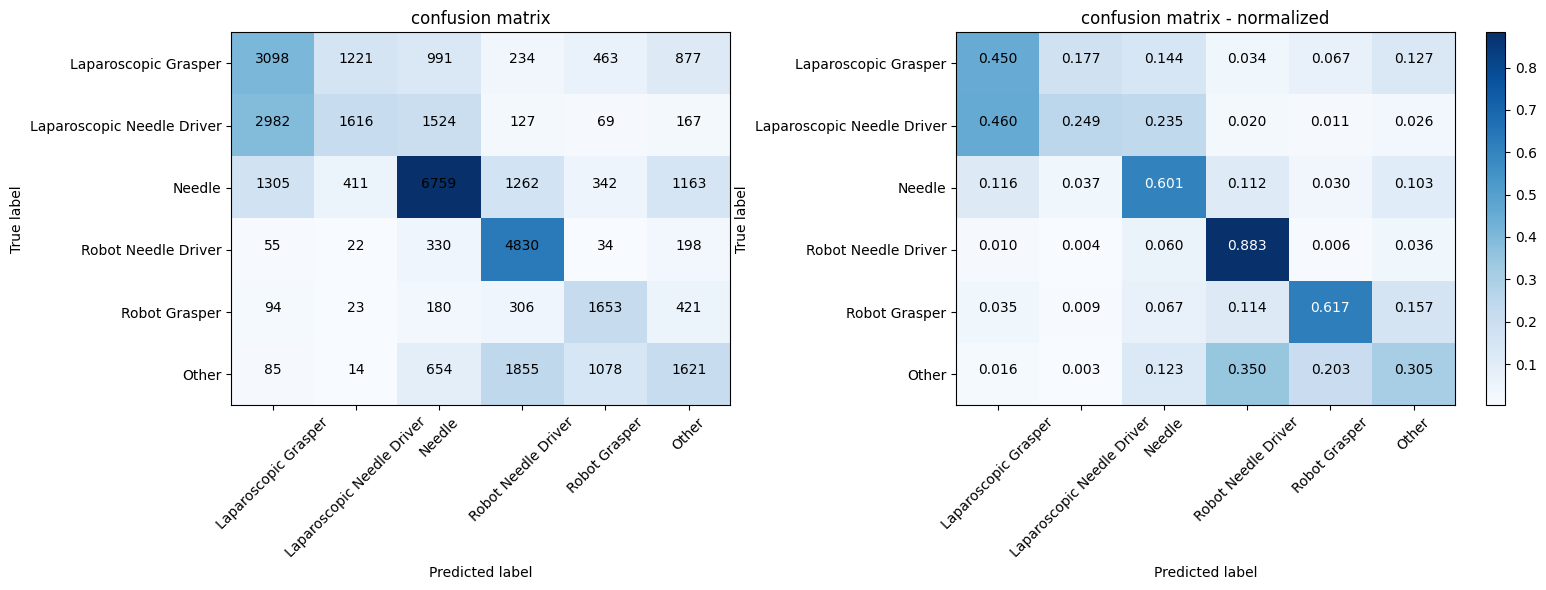

In [31]:
cnf_matrix = confusion_matrix(gt, pred)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(16,6))

plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names[1:], title='confusion matrix')

plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names[1:], normalize=True, title='confusion matrix - normalized')

In [34]:
all_gt = glob.glob(os.path.join(mask_dir,'*_gt.nrrd'))
all_preds = glob.glob(os.path.join(mask_dir,'*_pred.nrrd'))

## Segmentation DICE

In [36]:
data_vid = ['Hyst_LHC_4.4.2023c', '!Hyst_MedT_3.21.23d', 'Hyst_SurgU_3.21.23b']

In [ ]:
# num_classes = 7
# dic_coef = {k: [] for k in range(1,num_classes)}
# dice_score = {}

# for vid_name in data_vid:

#   for pred, gt in zip(all_gt, all_preds):

#     if vid_name in pred:
    
#       pred_img = sitk.GetArrayFromImage(sitk.ReadImage(pred))
#       gt_img = sitk.GetArrayFromImage(sitk.ReadImage(gt))

#       indices = np.unique(gt_img)

#       # dice scores
#       for i in indices[1:]:

#         bin_mask_gt = np.zeros_like(gt_img)
#         bin_mask_pred = np.zeros_like(pred_img)

#         bin_mask_gt[ gt_img !=i ] = 0
#         bin_mask_gt[ gt_img ==i ] = 1
        
#         bin_mask_pred[ pred_img !=i ] = 0
#         bin_mask_pred[ pred_img ==i ] = 1

#         dice = dice_coef(bin_mask_gt, bin_mask_pred)
#         dic_coef[i].append(dice)

#   fig3 = plt.figure(figsize=(num_classes*3,3)) 
#   print(vid_name)
#   for k in dic_coef.keys():
#     dice_score[k] = np.mean(dic_coef[k])
#     plt.subplot(1,num_classes,k)
#     s = sns.violinplot(data=dic_coef[k])
#     s.set_title(f'Dice coeff\n class {k}')
#   plt.show()


#   print(f"Average Dice score per class:\n {dice_score}")